In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import libpysal as ps
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


In [4]:
df_chicago=pd.read_csv('Crime/Crimes_-_2001_to_Present.csv',index_col='ID')
# clean the data without geocode and time stamp
df_chicago=df_chicago.dropna(subset=['Date','Location'])
df_chicago['Date']=pd.to_datetime(df_chicago['Date'])
# correct the value of crime type
df_chicago['Primary Type'].replace('CRIM SEXUAL ASSAULT','CRIMINAL SEXUAL ASSAULT',inplace=True)

In [5]:
df_chicago.head(20)


,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
ID,,,,,,,,,,,,,,,,,,,,,
10224853,HY411790,2015-09-05 16:15:00,041XX W FIFTH AVE,1570,SEX OFFENSE,PUBLIC INDECENCY,SIDEWALK,True,False,1132,...,24.0,26.0,17,1148735.0,1896483.0,2015,09/17/2015 11:37:18 AM,41.871884,-87.729404,"(41.871883543, -87.729403606)"
10224903,HY411941,2015-09-01 08:00:00,036XX W AUGUSTA BLVD,1751,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,APARTMENT,False,False,1112,...,27.0,23.0,20,1151766.0,1906421.0,2015,02/10/2018 03:50:01 PM,41.899095,-87.718014,"(41.899095398, -87.718013856)"
10224925,HY411895,2015-09-03 22:00:00,131XX S LANGLEY AVE,1753,OFFENSE INVOLVING CHILDREN,SEX ASSLT OF CHILD BY FAM MBR,RESIDENCE,False,False,533,...,9.0,54.0,02,1183246.0,1818302.0,2015,02/10/2018 03:50:01 PM,41.656611,-87.605131,"(41.656610975, -87.605130623)"
10225096,HY412036,2015-09-05 20:45:00,026XX W 47TH ST,1506,PROSTITUTION,SOLICIT ON PUBLIC WAY,STREET,True,False,922,...,12.0,58.0,16,1159360.0,1873402.0,2015,02/10/2018 03:50:01 PM,41.808335,-87.691028,"(41.808334931, -87.691028429)"
10225142,HY412197,2015-09-05 22:10:00,062XX S SACRAMENTO AVE,1710,OFFENSE INVOLVING CHILDREN,ENDANGERING LIFE/HEALTH CHILD,ALLEY,False,False,823,...,15.0,66.0,26,1157456.0,1863056.0,2015,02/10/2018 03:50:01 PM,41.779983,-87.698292,"(41.779982915, -87.698292215)"
10225229,HY412204,2015-09-05 23:15:00,066XX S HONORE ST,1563,SEX OFFENSE,CRIMINAL SEXUAL ABUSE,APARTMENT,False,False,726,...,15.0,67.0,17,1165157.0,1860630.0,2015,02/10/2018 03:50:01 PM,41.773166,-87.670128,"(41.77316612, -87.670127705)"
10225252,HY412283,2015-09-06 00:50:00,059XX W BELLE PLAINE AVE,281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,True,1624,...,38.0,15.0,02,1135859.0,1926645.0,2015,02/10/2018 03:50:01 PM,41.954891,-87.775958,"(41.954890553, -87.775957747)"
10225283,HY412303,2015-09-06 01:59:00,053XX S LAWNDALE AVE,291,CRIMINAL SEXUAL ASSAULT,ATTEMPT NON-AGGRAVATED,RESIDENCE,True,True,822,...,23.0,62.0,02,1152615.0,1868916.0,2015,02/10/2018 03:50:01 PM,41.796160,-87.715886,"(41.79616037, -87.715885925)"
10225305,HY412267,2015-09-05 07:30:00,002XX E ERIE ST,1755,OFFENSE INVOLVING CHILDREN,CHILD ABANDONMENT,HOSPITAL BUILDING/GROUNDS,False,False,1834,...,42.0,8.0,20,1178056.0,1904830.0,2015,12/18/2018 04:13:04 PM,41.894172,-87.621501,"(41.894171604, -87.621500665)"


In [145]:
type_size=df_chicago.groupby(['Primary Type']).size()
type_size

Primary Type
CRIMINAL SEXUAL ASSAULT       28807
DOMESTIC VIOLENCE                 1
HUMAN TRAFFICKING                67
OFFENSE INVOLVING CHILDREN    47964
PROSTITUTION                  68708
SEX OFFENSE                   26381
STALKING                       3805
dtype: int64

# Spatial data analysis

In [24]:
#get geometry point of data
df_chicago['Location'] = df_chicago.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)

In [28]:
# get geopandas frame
df_chicago=gpd.GeoDataFrame(df_chicago,geometry='Location')


To geocode data
The boundary data source is https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6


In [25]:
geof='Crime/Boundaries - Community Areas (current).geojson'
chicago_area=gpd.read_file(geof)
chicago_area=chicago_area[['community','area_numbe','geometry']]
chicago_area=chicago_area.rename(columns={'area_numbe':'area_num'})

In [26]:
chicago_area['area_num']=chicago_area['area_num'].apply(lambda x:float(eval(x)))

In [17]:
chicago_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   community  77 non-null     object  
 1   area_num   77 non-null     float64 
 2   geometry   77 non-null     geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 1.9+ KB


In [19]:
df_chicago.head()

,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,index_right,community,area_num
ID,,,,,,,,,,,,,,,,,,,,,
10224853,HY411790,2015-09-05 16:15:00,041XX W FIFTH AVE,1570,SEX OFFENSE,PUBLIC INDECENCY,SIDEWALK,True,False,1132,...,1148735.0,1896483.0,2015,09/17/2015 11:37:18 AM,41.871884,-87.729404,POINT (-87.72940 41.87188),26,WEST GARFIELD PARK,26
10232192,HY419551,2015-09-10 16:00:00,039XX W GLADYS AVE,1750,OFFENSE INVOLVING CHILDREN,CHILD ABUSE,RESIDENCE,False,True,1132,...,1150207.0,1898066.0,2015,02/10/2018 03:50:01 PM,41.876199,-87.723958,POINT (-87.72396 41.87620),26,WEST GARFIELD PARK,26
10329071,HY519515,2015-11-29 15:00:00,038XX W WILCOX ST,281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,OTHER,False,False,1122,...,1150799.0,1899061.0,2015,02/10/2018 03:50:01 PM,41.878918,-87.721758,POINT (-87.72176 41.87892),26,WEST GARFIELD PARK,26
10240564,HY428120,2015-09-17 20:00:00,039XX W WASHINGTON BLVD,281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1122,...,1150014.0,1900125.0,2015,02/10/2018 03:50:01 PM,41.881853,-87.724613,POINT (-87.72461 41.88185),26,WEST GARFIELD PARK,26
10242207,HY430128,2015-09-18 22:35:00,044XX W MADISON ST,1506,PROSTITUTION,SOLICIT ON PUBLIC WAY,SIDEWALK,True,False,1113,...,1146742.0,1899645.0,2015,02/10/2018 03:50:01 PM,41.880599,-87.736640,POINT (-87.73664 41.88060),26,WEST GARFIELD PARK,26


In [33]:
#set crs to the geo data frame
df_chicago=df_chicago.set_crs(chicago_area.crs)
df_chicago= df_chicago.sjoin(chicago_area, how='inner',predicate='within')



## spatial weight matrix
reference:[construct spatial weight matrix](https://pysal.org/libpysal/generated/libpysal.weights.W.html#libpysal.weights.W)

In [29]:
#chicago_area.plot()
# calculate the spatial weight matrix using the distance-based criteria
spaital_w_mat= ps.weights.DistanceBand.from_dataframe(chicago_area, threshold=500)
spaital_w_mat.histogram

[(76, 77)]

## examine the autocorrelation of crime counts


In [34]:
df_count=chicago_area.merge(df_chicago.groupby('community').size().reset_index(name='crime_count'),on='community')
df_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 77 entries, 0 to 76
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   community    77 non-null     object  
 1   area_num     77 non-null     float64 
 2   geometry     77 non-null     geometry
 3   crime_count  77 non-null     int64   
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 3.0+ KB


### Choropleth mapping: distribution of crime counts

In [35]:
import contextily


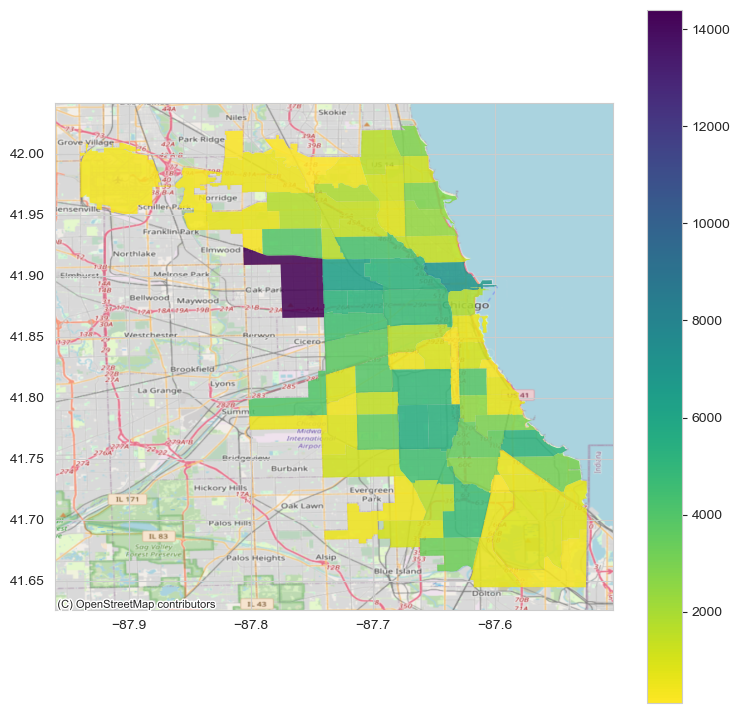

In [37]:
# visualise the distribution of crime count
#set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
df_count.plot(
    column='crime_count',
    k=5,

    edgecolor="white",
    linewidth=0.0,
    alpha=0.85,
    legend=True,
    cmap="viridis_r",
    ax=ax
)
# add basemap
contextily.add_basemap(
    ax,
    crs=df_count.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)

In [155]:
# generate weight
# apply the Queen's rule to construct
from libpysal.weights import Queen, Rook, KNN
w=Queen.from_dataframe(df_count)
# row-standardisation
w.transform='R'

In [169]:
# get the spatial lag of crime count
df_count['crime_count_lag']= ps.weights.spatial_lag.lag_spatial(w,df_count['crime_count'])

In [171]:
# get the standardised crime count and its spatial lag
df_count['crime_count_std']=df_count['crime_count']-df_count['crime_count'].mean()
df_count['crime_count_lag_std']=df_count['crime_count_lag']-df_count['crime_count_lag'].mean()

Text(0.5, 1.0, 'Moran Plot')

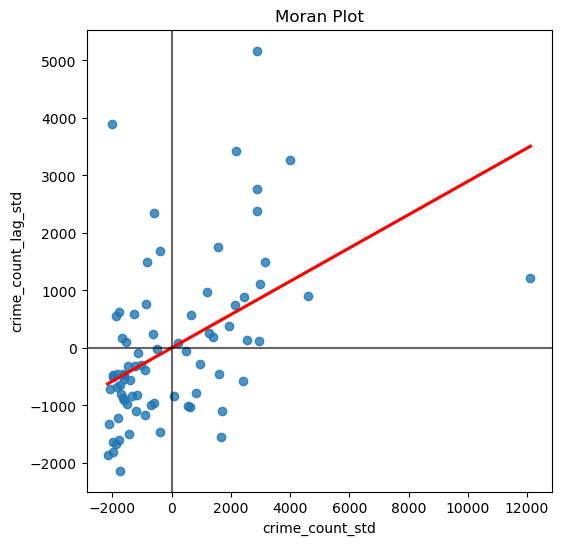

In [172]:
# create the Moran plot as a graphic tool to visualise the spatial autocorrelaiton
import seaborn
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="crime_count_std", y="crime_count_lag_std", data=df_count, ci=None,line_kws={'color':'r'}
);
ax.axvline(0,c='k',alpha=0.6)
ax.axhline(0,c='k',alpha=0.6)
ax.set_title('Moran Plot')

The plot shows a positive relationship between two variables, which indicates a positive spatial autocorrelation

In [174]:
# use the row standardised weight to calculate Moran's I
moran= esda.moran.Moran(df_count['crime_count'],w)
# retrive the value of Moran's I
moran.I

0.2893883391224936

In [175]:
# how likely it is to obtain a pattern like distribution of crime counts in a total randomness situation
# calculated empirical p-value
moran.p_sim

0.001

However, Moran's I does not indicate the type of clustering

Other global indicies
Geary'C

In [181]:
geary=esda.geary.Geary(df_count['crime_count'],w)
#access the estimate
print(f'estimated Geary c value: {geary.C}')
print(f'p_sim: {geary.p_sim}')


estimated Geary c value: 0.7373868693116572
p_sim: 0.007


## Local Indicators of Spatial Associations (LISAs)

Text(-2000, -1000, 'LL')

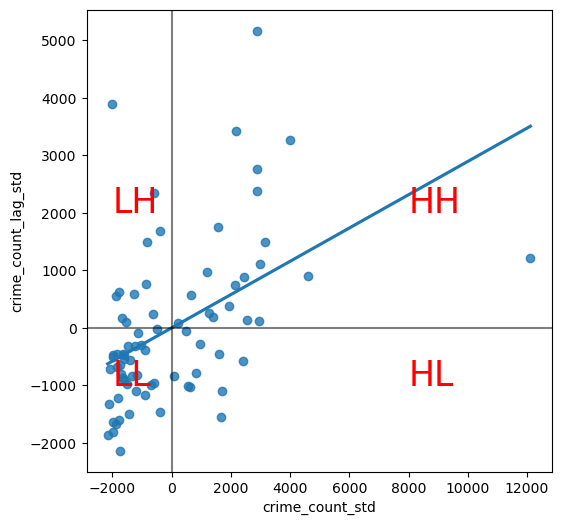

In [186]:
# visualise the four quadrants
# set up the figure and axis
f,ax = plt.subplots(1,figsize=(6,6))
#plot values
seaborn.regplot(x='crime_count_std', y='crime_count_lag_std',data=df_count,ci=None);
plt.axvline(0,c='k',alpha=0.5)
plt.axhline(0,c='k',alpha=0.5)
# add text label for each quadrant
# Add text labels for each quadrant
plt.text(8000, 2000, "HH", fontsize=25, c="r")
plt.text(8000, -1000, "HL", fontsize=25, c="r")
plt.text(-2000, 2000, "LH", fontsize=25, c="r")
plt.text(-2000, -1000, "LL", fontsize=25, c="r")

Now use LISA to identify the geographical clusters of values

In [138]:
from esda.moran import Moran_Local

In [187]:
lisa= esda.moran.Moran_Local(df_count['crime_count'],w)


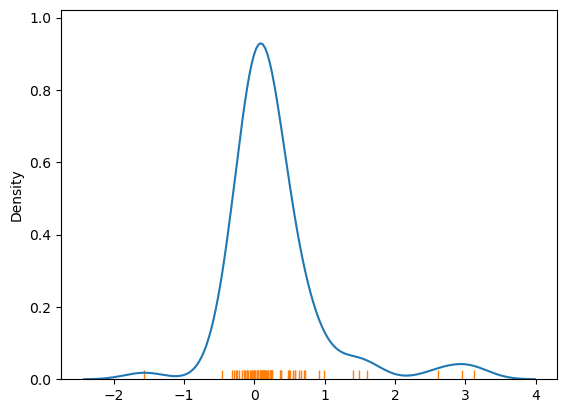

In [188]:
# check the distribution of local indicators: In the Is attribute
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

Note: the high positive values arise from value similarity in space, which can be due to either high values being surranded by high values or low values surrounded by low values. The local $ I_i $ alone cannot distinguish the 2 cases.
To tell if the statistics are significant or not, the following factors are visualised
1. Local statistic for each area
2. the quadrant each area is assigned into
3. significance of local statistics
4. combiniation of 2 and 3 -> so called **cluster map**

In [149]:
# cluster map
from splot import esda as esdaplot

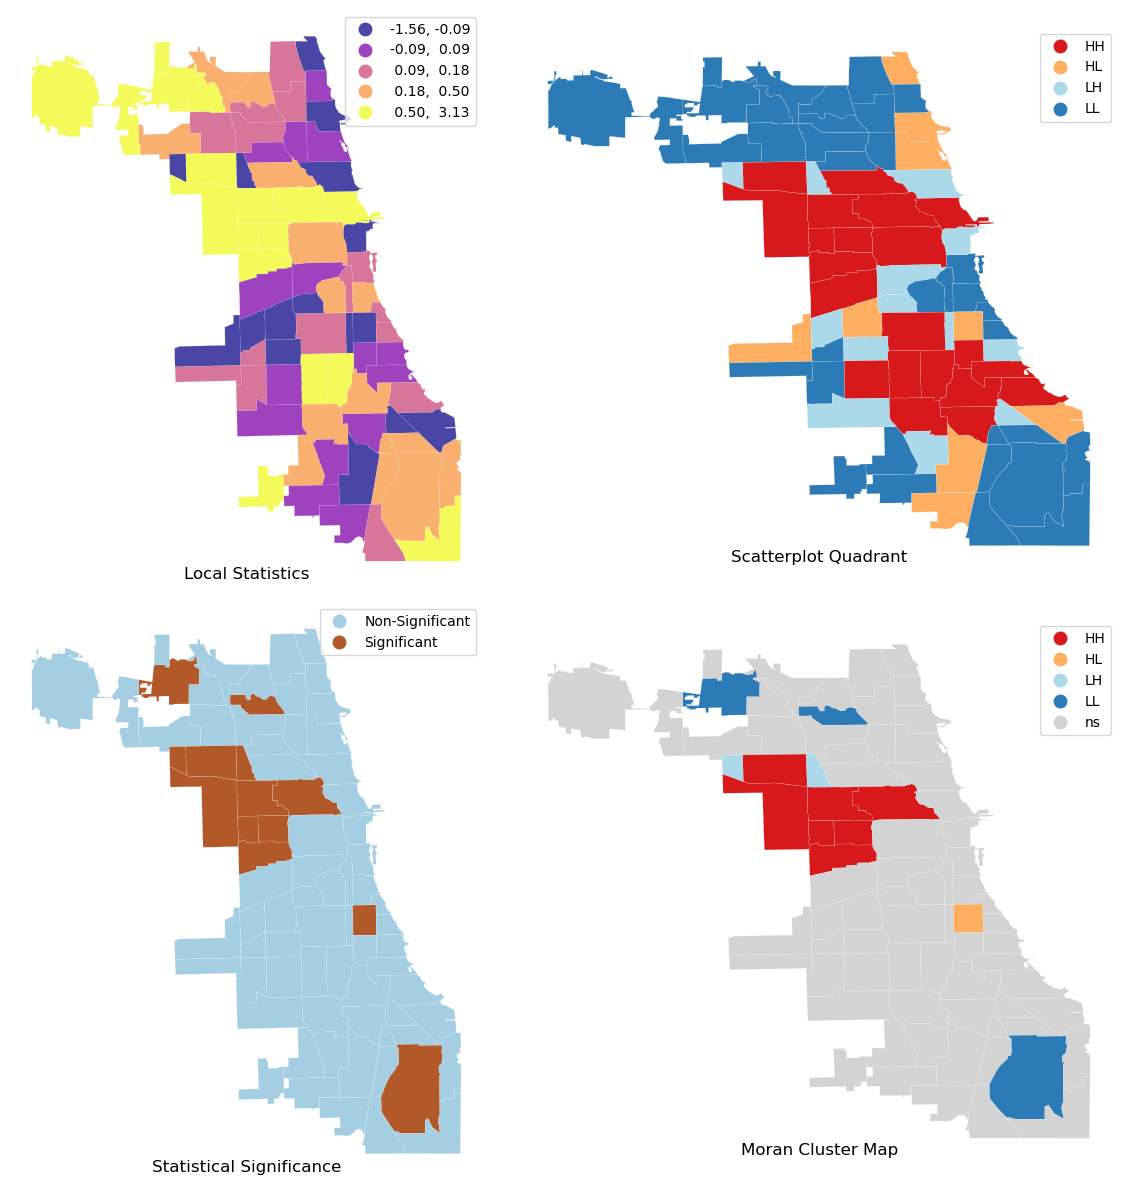

In [189]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
df_count.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, df_count, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=df_count.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
df_count.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, df_count, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

Note: care must be taken with the first 2 maps since the underlying statistical significance of values has not been considered

In [194]:
# check distribution of local moran's I in quadrants
# note: 1: HH; 2: LH; 3: LL; 4:HL;
print(f"count of different quadrants  {pd.value_counts(lisa.q)}")

count of different quadrants  3    34
1    21
2    13
4     9
dtype: int64


In [196]:
# check the significance of data
print(f"{(lisa.p_sim< 0.05).sum()*100/len(lisa.p_sim)}% of the communities are considered as a part of spatial cluser")

16.883116883116884% of the communities are considered as a part of spatial cluser


In [197]:
# link the local statistics to the data frame
# assign pseudo P-value to df
df_count['p-sim']=lisa.p_sim
#classify the significance
# `1` significant, vice versa
sig=1*(lisa.p_sim<0.05)
df_count['sig']=sig



In [198]:
df_count.head()

,community,area_num,geometry,crime_count,crime_count_lag,crime_count_std,crime_count_lag_std,p-sim,sig
0,DOUGLAS,35.0,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",1085,1301.750000,-1192.883117,-1103.761374,0.168,0
1,OAKLAND,36.0,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...",318,1902.666667,-1959.883117,-502.844707,0.399,0
2,FULLER PARK,37.0,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...",400,2962.166667,-1877.883117,556.655293,0.205,0
3,GRAND BOULEVARD,38.0,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...",3943,857.857143,1665.116883,-1547.654231,0.015,1
4,KENWOOD,39.0,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ...",680,1868.250000,-1597.883117,-537.261374,0.407,0


To summarise the statistics


In [202]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in df with labels for each polygon
df_count["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=df_count.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
df_count["labels"].head()

0    Non-Significant
1    Non-Significant
2    Non-Significant
3                 HL
4    Non-Significant
Name: labels, dtype: object

In [203]:
df_count['labels'].value_counts()

Non-Significant    64
HH                  7
LL                  3
LH                  2
HL                  1
Name: labels, dtype: int64

## LISA
$ G_i $
$ G_i ^* $
Get the hot spot and cold spot of crime counts in Chicago
NB: positive values only
NB: the local I and local G are complementary statistics: The local $ I $ indicates cluster and the local $ G $ shows which side the observation is on

In [145]:
# Gi
import esda
go_i = esda.getisord.G_Local(df_count['crime_count'], w)
# Gi*
go_i_star = esda.getisord.G_Local(df_count['crime_count'], w, star=True)

C:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\esda\getisord.py:596: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(


In [204]:
def g_map(g, db, ax):
    """
    Create a cluster map
    ...

    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    db     : GeoDataFrame
             Table aligned with values in `g` and containing
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    """
    ec = "0.8"

    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = db.loc[sig == False, "geometry"]
    ns.plot(ax=ax, color="lightgrey", edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = db.loc[(g.Zs > 0) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="red", edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = db.loc[(g.Zs < 0) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1)
    # Style and draw
    contextily.add_basemap(
        ax,
        crs=db.crs,
        source=contextily.providers.Stamen.TerrainBackground,
    )
    # Flag to add a star to the title if it's G_i*
    st = ""
    if g.star:
        st = "*"
    # Add title
    ax.set_title(f"G{st} statistic for Pct of Leave votes", size=15)
    # Remove axis for aesthetics
    ax.set_axis_off()
    return ax

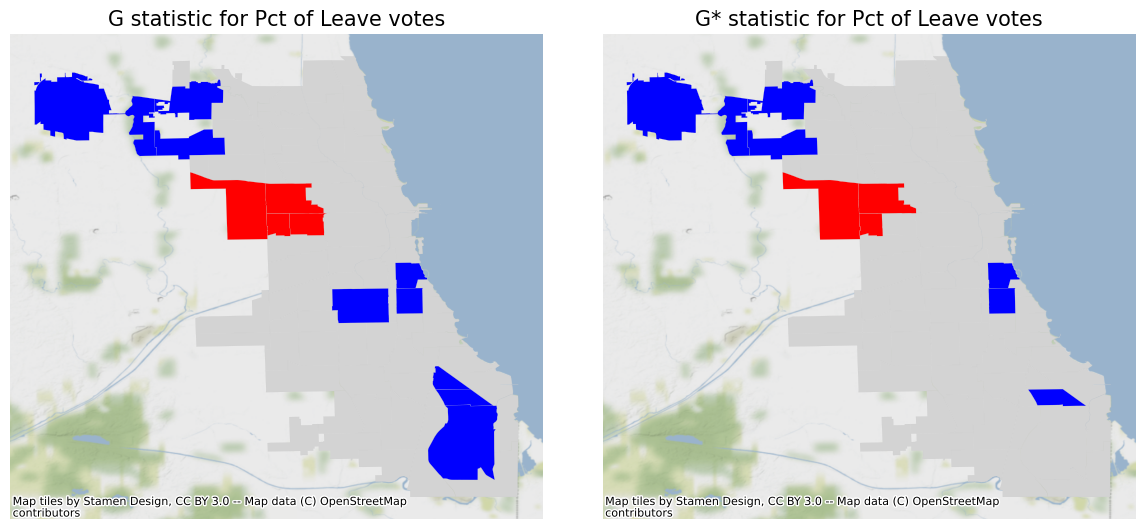

In [205]:
# Setup figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics
for g, ax in zip([go_i, go_i_star], axs.flatten()):
    # Generate the statistic's map
    ax = g_map(g, df_count, ax)
# Tight layout to minimise blank spaces
f.tight_layout()
# Render
plt.show()